## Описание данных

VASK0, VASK1, VASK2, VASK3, VASK4 – объёмы на 5 лучших асках текущего шага времени<br>
VBID0, VBID1, VBID2, VBID3, VBID4 – объёмы на 5 лучших бидах текущего шага времени<br>
VASK0_PREV, VASK1_PREV, VASK2_PREV, VASK3_PREV, VASK4_PREV – объёмы на 5 лучших асках предыдущего шага времени<br>
VBID0_PREV, VBID1_PREV, VBID2_PREV, VBID3_PREV, VBID4_PREV – объёмы на 5 лучших бидах предыдущего шага времени<br>
Y – целевая переменная, расширится ли спред на следующем шаге времени (0 – останется минимальным, 1 – расширится)
Необходимо предсказать вероятность для каждой строчки из обучающей выборки test.csv.<br>
Метрика задачи – AUC ROC.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
spred_train = pd.read_csv('tz/train.csv')
spred_test = pd.read_csv('tz/test.csv')

## Анализ и предобработка данных

Посмотрим на сами данные

In [3]:
spred_train.head()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,...,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
0,108,276,224,196,195,132,181,253,207,185,...,276,224,196,195,136,181,253,207,185,0
1,47,132,197,236,188,81,146,193,169,192,...,132,197,236,188,81,146,193,169,192,0
2,93,172,193,226,232,33,128,168,145,140,...,172,193,226,232,33,128,168,145,140,0
3,62,104,169,188,140,75,165,151,206,105,...,104,169,188,140,81,165,151,206,105,0
4,40,43,87,110,99,11,66,77,155,364,...,43,87,110,99,11,66,77,153,364,0


In [4]:
spred_test.head()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV
0,187,341,385,375,323,134,158,213,222,180,187,341,385,375,323,134,158,212,222,180
1,37,165,144,160,146,89,101,184,162,123,38,165,144,160,146,89,101,185,162,123
2,195,192,211,178,188,18,114,162,163,167,195,192,211,178,188,18,114,162,163,167
3,5,180,143,159,194,109,127,224,133,132,5,180,143,159,194,110,127,224,133,132
4,117,156,154,169,139,48,129,148,159,177,117,156,154,169,139,48,128,148,159,177


На первый взгляд train/test имеют общую структуру, проверим.

In [5]:
spred_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186590 entries, 0 to 186589
Data columns (total 21 columns):
VASK0         186590 non-null int64
VASK1         186590 non-null int64
VASK2         186590 non-null int64
VASK3         186590 non-null int64
VASK4         186590 non-null int64
VBID0         186590 non-null int64
VBID1         186590 non-null int64
VBID2         186590 non-null int64
VBID3         186590 non-null int64
VBID4         186590 non-null int64
VASK0_PREV    186590 non-null int64
VASK1_PREV    186590 non-null int64
VASK2_PREV    186590 non-null int64
VASK3_PREV    186590 non-null int64
VASK4_PREV    186590 non-null int64
VBID0_PREV    186590 non-null int64
VBID1_PREV    186590 non-null int64
VBID2_PREV    186590 non-null int64
VBID3_PREV    186590 non-null int64
VBID4_PREV    186590 non-null int64
Y             186590 non-null int64
dtypes: int64(21)
memory usage: 29.9 MB


In [6]:
spred_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93296 entries, 0 to 93295
Data columns (total 20 columns):
VASK0         93296 non-null int64
VASK1         93296 non-null int64
VASK2         93296 non-null int64
VASK3         93296 non-null int64
VASK4         93296 non-null int64
VBID0         93296 non-null int64
VBID1         93296 non-null int64
VBID2         93296 non-null int64
VBID3         93296 non-null int64
VBID4         93296 non-null int64
VASK0_PREV    93296 non-null int64
VASK1_PREV    93296 non-null int64
VASK2_PREV    93296 non-null int64
VASK3_PREV    93296 non-null int64
VASK4_PREV    93296 non-null int64
VBID0_PREV    93296 non-null int64
VBID1_PREV    93296 non-null int64
VBID2_PREV    93296 non-null int64
VBID3_PREV    93296 non-null int64
VBID4_PREV    93296 non-null int64
dtypes: int64(20)
memory usage: 14.2 MB


Пропусков в данных нет, тип данных у всех столбцов октуальный.

In [7]:
spred_train.describe()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,...,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
count,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,...,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000
mean,92.788981,178.840495,204.462640,205.277978,202.079436,92.270245,177.477716,203.058487,202.174195,197.799646,...,178.796431,204.430945,205.273975,202.076333,92.318286,177.438491,203.023479,202.169194,197.795123,0.010258
std,66.491713,62.138222,62.969816,65.644839,67.571850,65.281200,59.409587,58.546985,59.286325,61.265705,...,62.173445,62.981647,65.646947,67.573708,65.376130,59.444964,58.557993,59.289762,61.263966,0.100760
min,1.000000,1.000000,5.000000,1.000000,9.000000,1.000000,1.000000,1.000000,4.000000,3.000000,...,1.000000,5.000000,1.000000,9.000000,1.000000,1.000000,1.000000,4.000000,3.000000,0.000000
25%,41.000000,138.000000,162.000000,161.000000,156.000000,40.000000,137.000000,162.000000,161.000000,156.000000,...,138.000000,162.000000,161.000000,156.000000,40.000000,136.000000,162.000000,161.000000,156.000000,0.000000
50%,83.000000,170.000000,196.000000,194.000000,189.000000,83.000000,170.000000,197.000000,195.000000,188.000000,...,170.000000,196.000000,194.000000,189.000000,83.000000,170.000000,197.000000,195.000000,188.000000,0.000000
75%,131.000000,210.000000,232.000000,234.000000,232.000000,132.000000,211.000000,234.000000,233.000000,228.000000,...,210.000000,232.000000,234.000000,232.000000,132.000000,211.000000,234.000000,233.000000,228.000000,0.000000
max,647.000000,784.000000,666.000000,813.000000,738.000000,593.000000,657.000000,683.000000,687.000000,718.000000,...,784.000000,666.000000,813.000000,738.000000,593.000000,657.000000,683.000000,687.000000,718.000000,1.000000


In [8]:
spred_test.describe()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV
count,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000,93296.000000
mean,92.476355,178.953406,204.454521,205.374732,202.095760,92.278383,177.645022,202.957972,202.195164,197.819671,92.510869,178.908367,204.424048,205.368312,202.092094,92.314922,177.603713,202.928475,202.187275,197.818384
std,66.175816,62.286293,63.634183,66.001228,68.062758,65.014341,59.348882,58.378365,59.317456,61.338375,66.271320,62.316085,63.646742,66.000324,68.056626,65.115635,59.387653,58.397220,59.318053,61.342721
min,1.000000,3.000000,6.000000,4.000000,16.000000,1.000000,1.000000,2.000000,7.000000,11.000000,1.000000,3.000000,6.000000,4.000000,16.000000,1.000000,1.000000,2.000000,7.000000,11.000000
25%,41.000000,138.000000,162.000000,161.000000,156.000000,40.000000,137.000000,162.000000,161.000000,156.000000,41.000000,138.000000,162.000000,161.000000,156.000000,40.000000,137.000000,162.000000,161.000000,156.000000
50%,83.000000,170.000000,195.000000,194.000000,188.000000,83.000000,170.000000,197.000000,195.000000,188.000000,83.000000,170.000000,195.000000,194.000000,188.000000,83.000000,170.000000,197.000000,195.000000,188.000000
75%,131.000000,209.000000,232.000000,234.000000,232.000000,132.000000,212.000000,234.000000,233.000000,228.000000,131.000000,209.000000,232.000000,234.000000,232.000000,132.000000,211.000000,234.000000,233.000000,228.000000
max,601.000000,642.000000,826.000000,673.000000,967.000000,558.000000,640.000000,686.000000,684.000000,641.000000,601.000000,642.000000,826.000000,673.000000,967.000000,558.000000,640.000000,686.000000,684.000000,641.000000


Данные распределены нормально, особых выбросов или аномальных значений не наблюдается.

In [9]:
#Для дальнейшего анализа переименуем столбцы в привычный вид:
spred_train.columns = spred_train.columns.str.lower()
spred_test.columns = spred_test.columns.str.lower()

In [10]:
#Проверим баланс классов
#Всего измерений
spred_train['y'].count()

186590

In [11]:
#Спред расширился (кол-во раз)
spred_train[spred_train['y']==1]['y'].count()

1914

In [12]:
#Спред уменьшился (кол-во раз)
spred_train[spred_train['y']==0]['y'].count()

184676

Наблюдаеся сильный дисбаланс классов: спред расширяется заметно реже, нежели тех случаев, когда он остается минимальным.<br>
Уделим случаям расширения больше внимания, поскольку их "вес" больше.

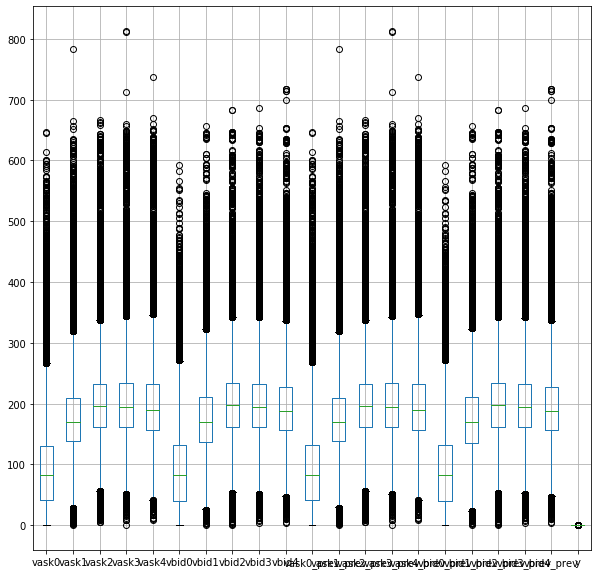

In [13]:
spred_train.boxplot(figsize=(10,10))

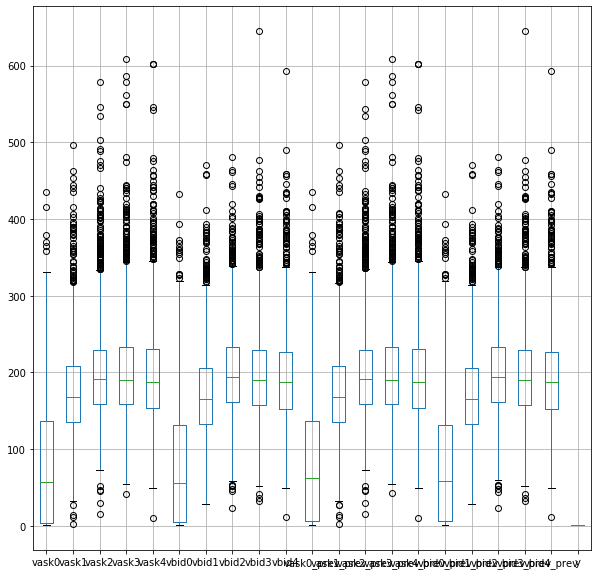

In [14]:
spred_train[spred_train['y']==1].boxplot(figsize=(10,10))

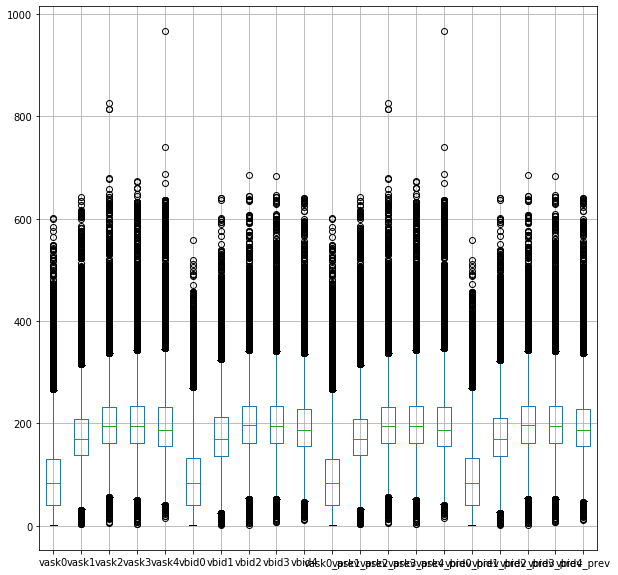

In [15]:
spred_test.boxplot(figsize=(10,10))

Распределение данных с расширяющимся спредом аналогична всему датафрейму, явных отличий не видно. Распределение тестовой и тренировочной выборок также совпадают.

### Добавление признаков

In [16]:
#разность между объемами лучших асков\бидов текущего дня
spred_train['diff0'] = spred_train['vbid0'] - spred_train['vask0']
#разность между объемами асков\бидов вчерашнего дня
spred_train['diff1'] = spred_train['vbid0_prev'] - spred_train['vask0_prev']
#если разность имеет тенденцию на увеличиние, то признак = 1, если наоборот то 0
for i in range(0, len(spred_train)):
    if spred_train.loc[i,'diff0'] > spred_train.loc[i,'diff1']:
        spred_train.loc[i,'upper'] = 1
    else:
        spred_train.loc[i,'upper'] = 0

В реальности можно было попытаться найти данные и за позавчерашний день, чтобы динамика изменения трендов была более отчетливой.

## Выбор модели

Обучим несколько моделей на разных алгоритмах, подберем лучшие параметры и выберем лучшую из всех для дальнейшего применения.

In [17]:
features = spred_train.drop(['y'], axis=1)
target = spred_train['y']

In [18]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [19]:
# поиск лучших параметров
# for i in range (1, 100, 5):
#     print("max_depth:", i)
#     for l in range (1, 32, 3):
#         print("estim_count:", l)
#         mod = DecisionTreeClassifier(max_depth=i, criterion='gini', random_state=12345)
#         mod.fit(features_train, target_train)
#         #predicted_valid = mod.predict(features_valid)
#         print("Модель:", mod)
#         preds_proba = mod.predict_proba(features_valid)
#         ras = roc_auc_score(target_valid, preds_proba[:,1])
#         print("RAC:", ras, "\n")


Определим несколько моделей с параметрами, подобранными ранее

In [20]:
dtc = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=12345)
lr = LogisticRegression(solver='liblinear')
cbc = CatBoostClassifier(iterations=431, learning_rate =0.094, eval_metric='AUC',
                         random_seed=0, logging_level='Silent')
xgbc = xgb.XGBClassifier(booster='gbtree', colsample_bylevel=1, learning_rate=0.11,
                            max_depth=5, n_estimators=120, verbosity=0) 

In [21]:
models = (dtc, lr, cbc, xgbc)

In [22]:
roc_auc_total = []

In [23]:
for mod in models:
    mod.fit(features_train, target_train)
    #predicted_valid = mod.predict(features_valid)
    print("Модель:", mod)
    preds_proba = mod.predict_proba(features_valid)
    ras = roc_auc_score(target_valid, preds_proba[:,1])
    print("ROC AUC:", ras, "\n")
    roc_auc_total.append(ras)

Модель: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
ROC AUC: 0.8801653185878713 

Модель: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
ROC AUC: 0.7269733767747141 

Модель: <catboost.core.CatBoostClassifier object at 0x7f1bdd104190>
ROC AUC: 0.9037649788175947 

Модель: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              co

In [24]:
names = ['Случайный лес', 'Логистическая регрессия', 'CatBoost', "XGBoost"]

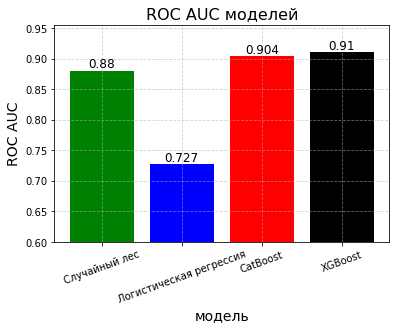

In [25]:
plt.bar(names, roc_auc_total, color='gbrk')
plt.title('ROC AUC моделей', fontsize=16)
plt.xlabel("модель", fontsize=14)
plt.ylabel("ROC AUC", fontsize=14)
plt.ylim(.6)
plt.grid(linestyle='--', alpha=0.6)
ra_total_round = [round(i,3) for i in roc_auc_total]
for i, val in enumerate(ra_total_round):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':100, 'size':12})
plt.xticks(rotation=20)
plt.show()

Из полученных моделей лучше остальных себя зарекомендовал XGBoost с roc_auc_score = 0.91. С данной моделью и будем работать далее.

### Анализ полученной модели

In [26]:
xgbc.fit(features_train, target_train)
predicted_valid = xgbc.predict(features_valid)

In [27]:
#доля правильных ответов, если заменить все значения нулями:
ifnull = spred_train[spred_train['y']==0]['y'].count() / spred_train['y'].count()
#Поскольку имеем дело с временными рядами,
#то стоит проверить замену таргета предыдущим значением
orders = spred_train['y']
train_orders, test_orders = train_test_split(orders, shuffle=False, test_size=0.1)
pred_previous = test_orders.shift()
pred_previous.iloc[0] = train_orders.iloc[-1]

In [28]:
print("Предсказано расширений:",sum(predicted_valid==1),
     "\nДоля правильных предсказаний расширений:", sum(predicted_valid==1) / sum(target_valid==1))
print("\nДоля правильных ответов",
     "\nзаполнения нулями:", ifnull,
     "\nзаполнения предыдущим значением:", accuracy_score(test_orders, pred_previous),
     "\nполученной модели:", accuracy_score(target_valid, predicted_valid),
     "\n\nТочность:",precision_score(target_valid, predicted_valid),
     "\nПолнота:", recall_score(target_valid, predicted_valid),
     "\nf1-метрика:",f1_score(target_valid, predicted_valid)
     )

Предсказано расширений: 10 
Доля правильных предсказаний расширений: 0.0273224043715847

Доля правильных ответов 
заполнения нулями: 0.9897422155528164 
заполнения предыдущим значением: 0.9765260732086393 
полученной модели: 0.9901924004501849 

Точность: 0.5 
Полнота: 0.01366120218579235 
f1-метрика: 0.02659574468085106


Кроме метрики ROC-AUC остальные метрики крайненизкие, за счет доли предсказанных решений. Сделаем Upsampling и обучим модель заново.

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 7)

In [30]:
xgbc.fit(features_upsampled, target_upsampled)
predicted_valid = xgbc.predict(features_valid)
preds_proba = xgbc.predict_proba(features_valid)
ras_fin = roc_auc_score(target_valid, preds_proba[:,1])

In [31]:
#доля правильных ответов, если заменить все значения нулями:
ifnull = spred_train[spred_train['y']==0]['y'].count() / spred_train['y'].count()
#Поскольку имеем дело с временными рядами,
#то стоит проверить замену таргета предыдущим значением
orders = spred_train['y']
train_orders, test_orders = train_test_split(orders, shuffle=False, test_size=0.1)
pred_previous = test_orders.shift()
pred_previous.iloc[0] = train_orders.iloc[-1]
print("Предсказано расширений:",sum(predicted_valid==1),
     "\nДоля предсказаний расширений:", sum(predicted_valid==1) / sum(target_valid==1))
print("\nДоля правильных ответов",
     "\nзаполнения нулями:", ifnull,
     "\nзаполнения предыдущим значением:", accuracy_score(test_orders, pred_previous),
     "\nполученной модели:", accuracy_score(target_valid, predicted_valid),
     "\n\nТочность:",precision_score(target_valid, predicted_valid),
     "\nПолнота:", recall_score(target_valid, predicted_valid),
     "\nf1-метрика:",f1_score(target_valid, predicted_valid),
     "\nROC AUC score:", ras_fin
     )

Предсказано расширений: 346 
Доля предсказаний расширений: 0.9453551912568307

Доля правильных ответов 
заполнения нулями: 0.9897422155528164 
заполнения предыдущим значением: 0.9765260732086393 
полученной модели: 0.9852618039551959 

Точность: 0.23410404624277456 
Полнота: 0.22131147540983606 
f1-метрика: 0.22752808988764045 
ROC AUC score: 0.9076751984852304


Доля правильных ответов при таком дисбалансе не играет важную роль, а прочие метрики увеличелись.

Проверим модель с помощью кросс-валидации

In [32]:
scores = cross_validate(xgbc, features_train, target_train, cv=5, scoring='roc_auc')
scores

{'fit_time': array([31.72756529, 30.10993648, 32.53588414, 30.91466832, 30.93908668]),
 'score_time': array([0.21733546, 0.23271632, 0.22006631, 0.22948289, 0.22615743]),
 'test_score': array([0.90227646, 0.90757101, 0.88077422, 0.89107286, 0.89065741])}

In [33]:
print("mean scores:", scores['test_score'].mean())

mean scores: 0.8944703909049447


Наблюдается переобучение, но не большое.

Посмотрим какие признаки вносят наибольшее влияние:

In [34]:
fi_new = pd.Series(xgbc.feature_importances_, index=features.columns)
fi_new = fi_new / fi_new.sum()

Text(0, 0.5, 'корреляция')

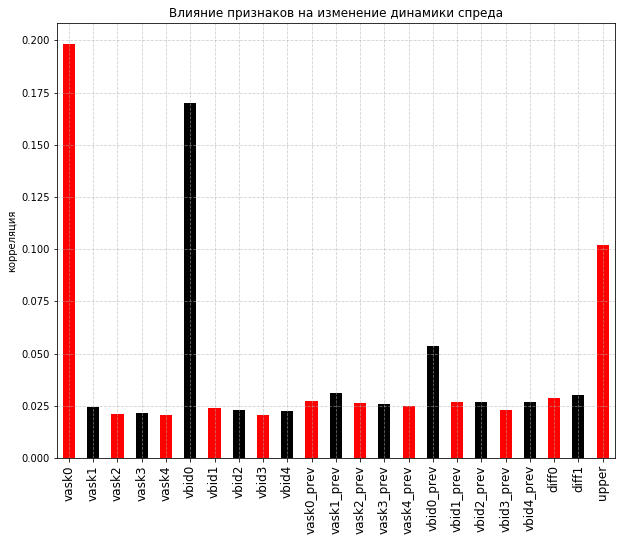

In [35]:
plt.figure(figsize=(10,8))
fi_new.plot(kind='bar', grid=True, color=['r','k'])
plt.grid(linestyle='--', alpha=0.6)
plt.xticks(rotation=90, fontsize = 12)
plt.title("Влияние признаков на изменение динамики спреда")
plt.ylabel("корреляция")

как и ожидалось - лучшие объемы асков и бидов вносят максимальное значение для нахождения таргета.

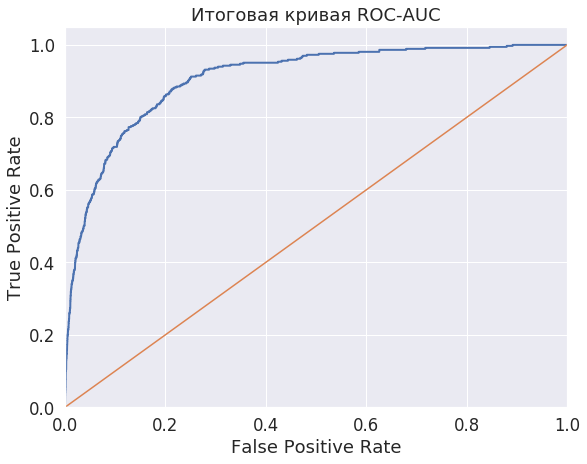

In [36]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(9, 7))
fpr, tpr, thresholds = roc_curve(target_valid, preds_proba[:,1], pos_label=1)
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Итоговая кривая ROC-AUC')
plt.show()

Итоговая модель имеет ROC AUC Score = 0.91, кривая ROC AUC представлена выше.

### Применение модели

Используем нашу полученную модель на тестовом датасете для получения итоговых вероятностей.

In [37]:
spred_test.head(1)

,vask0,vask1,vask2,vask3,vask4,vbid0,vbid1,vbid2,vbid3,vbid4,vask0_prev,vask1_prev,vask2_prev,vask3_prev,vask4_prev,vbid0_prev,vbid1_prev,vbid2_prev,vbid3_prev,vbid4_prev
0,187,341,385,375,323,134,158,213,222,180,187,341,385,375,323,134,158,212,222,180


In [38]:
#разность между объемами лучших асков\бидов текущего дня
spred_test['diff0'] = spred_test['vbid0'] - spred_test['vask0']
#разность между объемами асков\бидов вчерашнего дня
spred_test['diff1'] = spred_test['vbid0_prev'] - spred_test['vask0_prev']
#если разность имеет тенденцию на увеличиние, то признак = 1, если наоборот то 0
for i in range(0, len(spred_test)):
    if spred_test.loc[i,'diff0'] > spred_test.loc[i,'diff1']:
        spred_test.loc[i,'upper'] = 1
    else:
        spred_test.loc[i,'upper'] = 0

In [39]:
final_preds = xgbc.predict_proba(spred_test)

In [40]:
out = pd.DataFrame(final_preds[:,1], columns=['Y_PRED'])

In [41]:
out.to_csv("tz/out_pred.csv", index=False)